#### Bayesian Inference Tutorial

- Posterior: $P(\theta|D) = \frac{P(D|\theta) P(\theta)}{P(D)}$
- Given all values of $\theta$, we can compute the probability of observing our data. This is called the likelihood $P(D|\theta)$
- Evidence: $P(D) = \int_{\theta} P(D| \theta) P(\theta) \text{d} \theta$
    - This is the marginal likelihood where all the parameters are marginalized.
    - This integral is the problem. where $\theta$ is high dimension. 

- Data: height of basketball players

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

lengths = np.array([195, 182])

- Assumption: the **true posterior** follows a Gaussian distribution which is parameterized with a mean $\mu$ and $\sigma$.
- For a *reasonable domain* of these parameters $\theta = \{ \mu , \sigma \}$ we can compute the likelihood $P(D|\theta) = P(D| \mu, \sigma)$.
    - for real entire domain (the whole real number, we can't compute this)

In [2]:
# lets create a grid of our two parameters
mu = np.linspace(start=150, stop=250, num=50)
sigma = np.linspace(0, 15, num=50)[::-1]

mm, ss = np.meshgrid(mu, sigma)  # just broadcasted parameters

In [3]:
ss.shape

(50, 50)

In [4]:
p = stats.norm(mm, ss).pdf(lengths[0])  # likelihood of observing the data '195'. 

/home/ash/anaconda3/envs/rnd/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [5]:
p.shape

(50, 50)

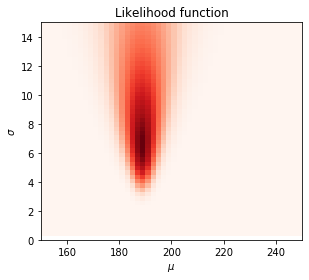

In [6]:
likelihood = stats.norm(mm, ss).pdf(lengths[0]) * stats.norm(mm, ss).pdf(lengths[1])
aspect = mm.max() / ss.max() / 3
extent = [mm.min(), mm.max(), ss.min(), ss.max()]

plt.imshow(likelihood, cmap='Reds', aspect=aspect, extent=extent)
plt.title('Likelihood function')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.show()

If we would infer the most likely parameters $\theta$ based on only the likelihood we would choose $\mu=190$ and $\sigma=6$.

#### Prior distribution
- We believe the means follow a Gaussian distribution: $\mu \sim \mathcal{N}(200, 15^2)$
- and the prior of  variance: $\sigma \sim \mathcal{Cauchy}(0, 10^2)$

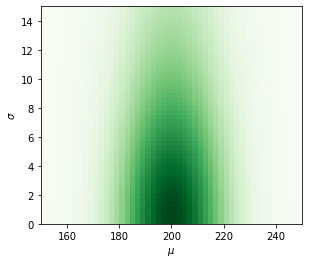

In [7]:
prior = stats.norm(200, 15).pdf(mm) * stats.cauchy(0, 10).pdf(ss)

plt.imshow(prior, cmap='Greens', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.show()

#### Posterior distribution
- With the *reasonable idea* in which domain we need to search, we can compute the posterior directly by applying Bayes’ rule.
- Search space: total two dimension, each dimension 50, we evaluate the posterior of $50^2=2500$ points in parameter space.
- np.nan_to_num(unnormalized_posterior).sum() -> $P(D)$ this is the hard part. (normally intractable)

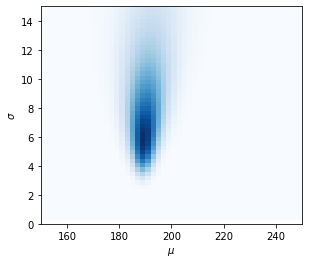

In [8]:
unnormalized_posterior = prior * likelihood
posterior = unnormalized_posterior / np.nan_to_num(unnormalized_posterior).sum()
plt.imshow(posterior, cmap='Blues', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.show()

- In the plot showing the posterior distribution we first normalized the <code>unnormalized_posterior</code> by adding this line;
<code>posterior = unnormalized_posterior / np.nan_to_num(unnormalized_posterior).sum()</code>. The only thing this did was ensuring that the integral over the posterior equals 1; $\int_{\theta} P(\theta|D) \text{d}\theta =1$. This is necessary if we want the posterior distribution to be a probability distribution.
- Thus, if we plot the *unnormalized posterior*, we would see exactly the same plot.
- If we just want the most probable parameters, we don't have to compute $P(D)$, but if we want a exact probablity of $\theta_i$, we need to calculate the evidence.
    - e.g) prior x likelihood is not a probablity this number means nothing. 

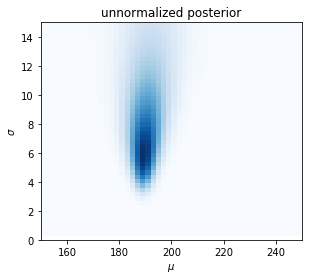

In [9]:
plt.imshow(unnormalized_posterior, cmap='Blues', aspect=aspect, extent=extent)
plt.title('unnormalized posterior')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.show()

#### MCMC
- If $P(D)$ is intractable, can we ignore the intractable term and just sample directly from true posterior? (number of drawn samples is proportional to the true posterior distribution)
- This is done by exploring $\theta$ space by taking a random walk and computing the joint probability $P(\theta, D)$ and keep the parameter sample of $\theta_i$ according to the following acceptance probability:
$$ P_\text{acceptance} = \text{min}(1, \frac{P(D|\theta^*)P(\theta^*)}{P(D|\theta)P(\theta)})$$
    - Where $\theta=$ current state, $\theta^*=$ proposal.
- The proposals that were accepted are samples from the true posterior distribution. This is very powerful, as we are able to directly sample from, and therefore approximate, the real posterior.

In [10]:
import pymc3 as pm

In [11]:
with pm.Model():
    # priors
    mu = pm.Normal('mu', mu=200, sd=15)
    sigma = pm.HalfCauchy('sigma', 10)
    
    # likelihood
    observed = pm.Normal('observed', mu=mu, sd=sigma, observed=lengths)
    # sample
    trace = pm.sample(draws=10000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


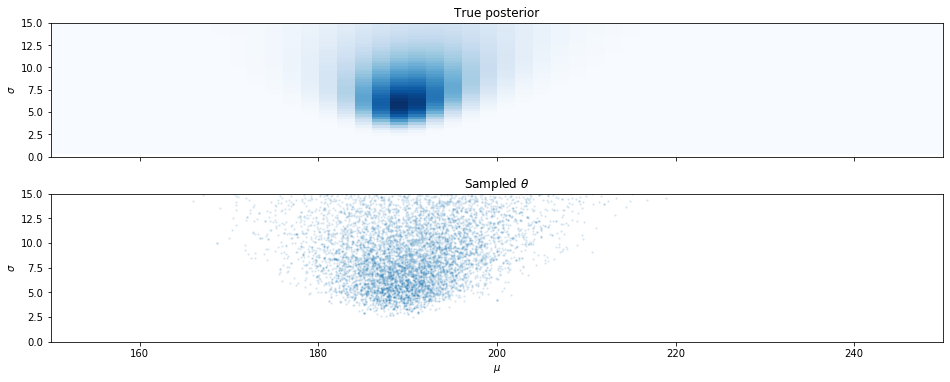

In [12]:
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (16, 6))
axes[0].imshow(posterior, cmap='Blues', extent=extent, aspect=1)
axes[0].set_ylabel('$\sigma$')
axes[1].scatter(trace['mu'], trace['sigma'], s=2, alpha=0.1)
axes[1].set_ylabel('$\sigma$')
axes[0].set_title('True posterior')
axes[1].set_title('Sampled $\\theta$')
plt.xlabel('$\mu$')
plt.xlim(150, mm.max())
plt.ylim(0, ss.max())
plt.show()

#### Variational Inference
- Sampling with MCMC is often too slow especially in deep learning. 
- Instead of 
    - computing the posterior distribution (Bayes rule)
    - approximating the true posterior by sampling from it (MCMC)
- In VI, we choose a simple distribution and try to make it resemble the true posterior as close as possible.

Can we compute the KL-divergence $D_{\text{KL}}(Q(\theta) \: || \: P(\theta|D))$ when we don&rsquo;t know the true posterior?

<p>$$ D_{\text{KL}}(Q(\theta) \: || \: P(\theta|D))  = \int_{\theta} Q(\theta) \log \frac{Q(\theta)}{P(\theta|D)}\text{d}\theta $$</p>

<p>$$ D_\text{KL}  = \int_{\theta} Q(\theta) \log \frac{Q(\theta)P(D)}{P(\theta, D)}\text{d}\theta $$</p>

<div>
$$ D_{\text{KL}}  = \int_{\theta} Q(\theta) \log \frac{Q(\theta)}{P(\theta, D)}\text{d}\theta + \int_{\theta} Q(\theta) \log P(D) \text{d} \theta $$</div>

<p>As $P(D)$ is not parameterized by $\theta$ and $\int_{\theta} Q(\theta) \text{d} \theta = 1$ we can write:</p>

<p>$$ D_\text{KL}  = \int_{\theta} Q(\theta) \log \frac{Q(\theta)}{P(\theta, D)}\text{d}\theta +  \log P(D) $$</p>

<p>$$ D_\text{KL}  = \log P(D) -\int_{\theta} Q(\theta) \log \frac{P(\theta, D)}{Q(\theta)}\text{d}\theta  $$</p>

<p>And now we can see that the second term on the <em>rhs</em> is actually the <strong>ELBO</strong>, which can be written in expectation (over $\theta$) form.</p>

<p>$$ D_\text{KL}  = \log P(D) - E_{\theta \sim Q}[\log \frac{P(\theta, D)}{Q(\theta)} ] $$</p>

- In order to <strong>minimize KL-divergence</strong> we need to <strong>maximize the ELBO</strong> and we don&rsquo;t need to know the value of $P(D)$.
- The ELBO is something we can compute as it only contains the variational distribution $Q(\theta)$ (which we determine), and the joint probability $P(\theta, D)$, i.e. the <strong>prior times the likelihood.

$$ \text{ELBO}  = E_{\theta \sim Q}[\log \frac{P(D|\theta)P(\theta)}{Q(\theta)} ] $$

$$ \text{ELBO}  = E_{\theta \sim Q}[\log P(D|\theta)] +  E_{\theta \sim Q}[\log \frac{P(\theta)}{Q(\theta)}]$$

If we rewrite the $E_{\theta \sim Q}[\log \frac{P(\theta)}{Q(\theta)}]$ in the integral form $\int_{\theta} Q(\theta)\log\frac{P(\theta)}{Q(\theta)}d\theta$, we can observe that this is the KL-divergence between the prior $P(\theta)$ and the variational distribution $Q(\theta)$. Resulting in an ELBO defined by the *reconstruction error* and $-D_{KL}(Q(\theta)||P(\theta)).$

$$ \text{ELBO}  = E_{\theta \sim Q}[\log P(D|\theta)] - D_{KL}(Q(\theta)||P(\theta))$$

#### Mean Field Approximation
- We need to define a distribution $Q(\theta)$ that approximates the posterior. One approach is called the Mean Field Approximation.
- We define the variational distribution as a product of independent partitions of $\theta$ (the partitions can span multiple dimensions, but can also be one dimensional).
$$ Q_\text{mfa}(\theta) = \prod_{i=1}^N Q_i(\theta_i) $$
- By defining a mean field approximation we end up with an &lsquo;easy to work with&rsquo; distribution.